In [1]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import os

os.chdir('../')
from function import make_data

# Using the provided make_data function to generate data
df = make_data(dt=0.01, total_time=50)

# Preparing the training data
train = df.iloc[:int(len(df)*0.8)]
train_x = train[['u', 'time']].values
train_y = train['f'].values

# Preparing the test data
test = df.iloc[int(len(df)*0.8):]
test_x = test[['u', 'time']].values
test_y = test['f'].values

In [2]:
def boucwen_dynamics(u, z, A, B, n):
    Z_dot = u - A * z - B * tf.abs(u) * tf.abs(z)**(n-1) * z
    return Z_dot

In [3]:
import tensorflow as tf

class NeuralODE(tf.keras.Model):
    def __init__(self):
        super(NeuralODE, self).__init__()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.dense3 = tf.keras.layers.Dense(1)
    
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)


In [4]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(model, inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_object(predictions, targets)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


In [5]:
from pyswarm import pso

In [6]:
import numpy as np

In [7]:
train_y_diff = np.diff(train_y, axis=0)
train_y_diff = np.append(train_y_diff, [0])

In [16]:
def loss_function(params):
    A, B, n = params
    predictions = boucwen_dynamics(train_x[:, 0], train_x[:, 1], A, B, n)
    
    # 실제 변화량과의 MSE 계산
    mse = np.mean((predictions - train_y_diff) ** 2)
    return mse

In [17]:
lb = [-10, -10, -10]  # 각 파라미터의 최소값
ub = [10, 10, 10]    # 각 파라미터의 최대값

# PSO를 사용하여 손실 함수를 최소화합니다.
optimized_params, _ = pso(loss_function, lb, ub, maxiter=1000)

Stopping search: Swarm best objective change less than 1e-08


In [18]:
optimized_params

array([ 2.07842620e-04, -1.81720534e-04,  1.44062917e+00])

In [19]:
A, B, n = optimized_params

In [22]:
# Prepare the inputs for the Neural ODE using the compute_boucwen_dynamics function
train_inputs = boucwen_dynamics(train_x[:, 0], train_x[:, 1], A, B, n)
test_inputs = boucwen_dynamics(test_x[:, 0], test_x[:, 1], A, B, n)

In [23]:
import matplotlib.pyplot as plt

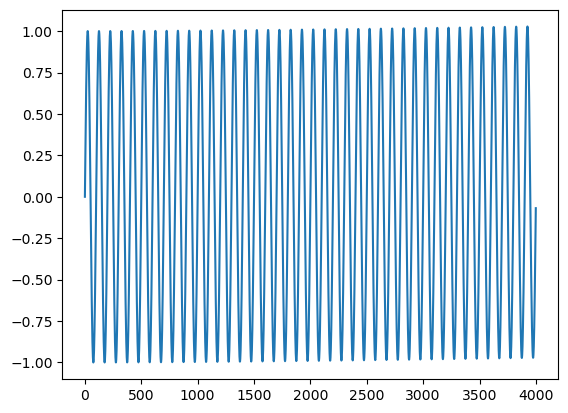

In [24]:
plt.plot(train_inputs)

In [25]:
train_inputs = tf.expand_dims(train_inputs, axis=-1)
test_inputs = tf.expand_dims(test_inputs, axis=-1)

In [26]:
train_inputs

<tf.Tensor: shape=(4000, 1), dtype=float64, numpy=
array([[ 0.        ],
       [ 0.06278846],
       [ 0.12532916],
       ...,
       [-0.18877628],
       [-0.12901757],
       [-0.06878413]])>

In [27]:
# Initialize the Neural ODE model
neural_ode_model = NeuralODE()

# Training loop
EPOCHS = 5000
for epoch in range(EPOCHS):
    loss = train_step(neural_ode_model, train_inputs, train_y)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

Epoch 0, Loss: 0.6214465029667583
Epoch 10, Loss: 0.2990345319003925
Epoch 20, Loss: 0.1779472004470432
Epoch 30, Loss: 0.14280058402726487
Epoch 40, Loss: 0.13911009508976593
Epoch 50, Loss: 0.13495769339144578
Epoch 60, Loss: 0.13097969849943658
Epoch 70, Loss: 0.1273066175565572
Epoch 80, Loss: 0.12392434722056925
Epoch 90, Loss: 0.12074787658065876
Epoch 100, Loss: 0.11815984476447568
Epoch 110, Loss: 0.11600615678774073
Epoch 120, Loss: 0.1142362532844234
Epoch 130, Loss: 0.11280734408543085
Epoch 140, Loss: 0.11165058123640206
Epoch 150, Loss: 0.11070054330991848
Epoch 160, Loss: 0.10990488871108323
Epoch 170, Loss: 0.10924883799475307
Epoch 180, Loss: 0.10870712966169185
Epoch 190, Loss: 0.10824506405353779
Epoch 200, Loss: 0.1078537428121392
Epoch 210, Loss: 0.1075193681972677
Epoch 220, Loss: 0.10723541651126534
Epoch 230, Loss: 0.10699310091939239
Epoch 240, Loss: 0.10678645209199082
Epoch 250, Loss: 0.10661133425893292
Epoch 260, Loss: 0.10646364173238655
Epoch 270, Loss: 0.

In [28]:
# Predictions
predictions = neural_ode_model(test_inputs)

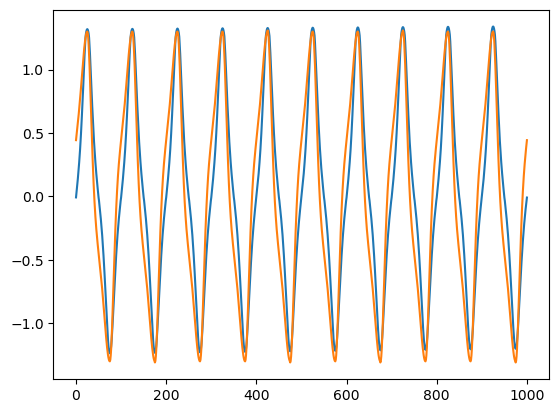

In [29]:
plt.plot(predictions)
plt.plot(test_y)

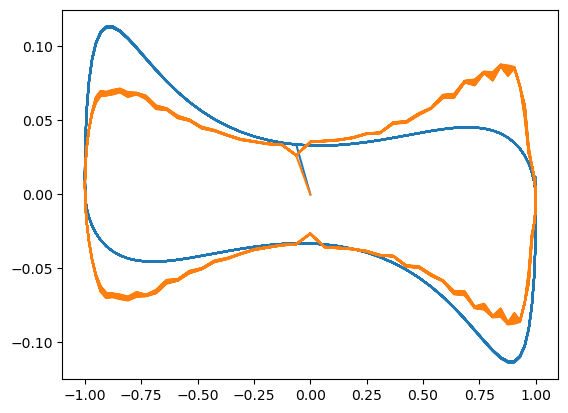

In [33]:
plt.plot(test_x[:,0], np.append(np.diff(test_y, axis=0).reshape(-1),0))
plt.plot(test_x[:,0], np.append(np.diff(predictions.numpy().reshape(-1), axis=0),0))

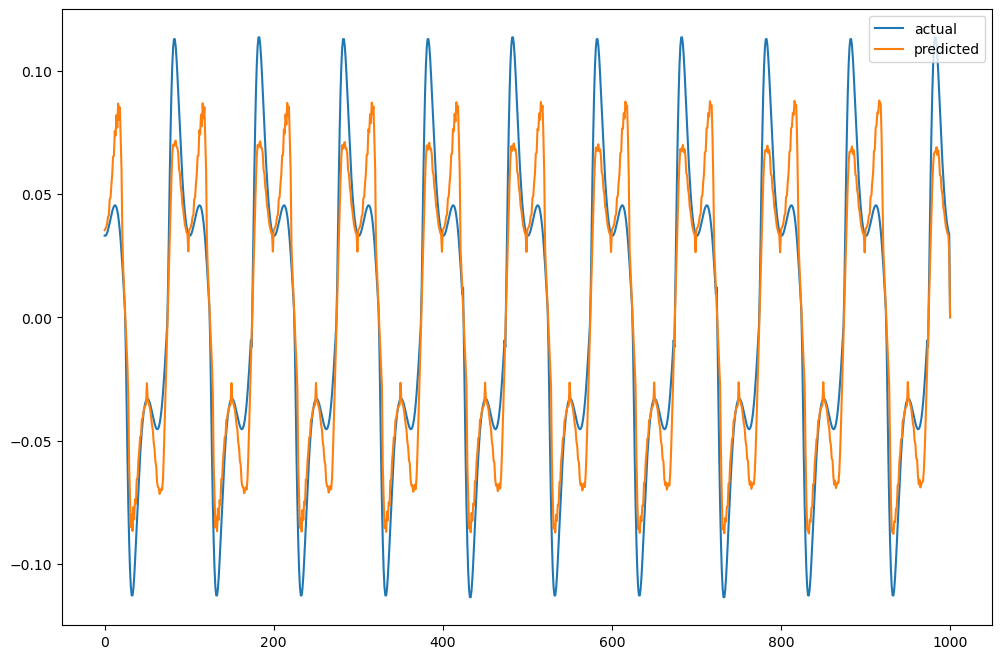

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(np.append(np.diff(test_y, axis=0).reshape(-1),0), label = 'actual')
plt.plot(np.append(np.diff(predictions.numpy().reshape(-1), axis=0),0), label = 'predicted')
plt.legend()
plt.show()

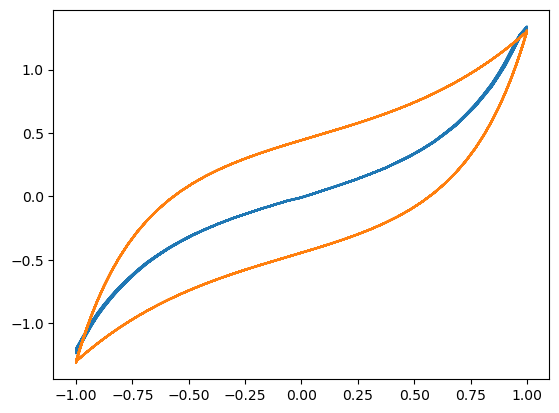

In [34]:
plt.plot(test_x[:,0], predictions)
plt.plot(test_x[:,0], test_y)